In [55]:
include("autodiff/graph.jl")
include("autodiff/operations.jl")
include("layers/layers.jl")

adjust_params (generic function with 1 method)

In [56]:
using MLDatasets, Flux

train_data = MLDatasets.MNIST(split=:train)
test_data = MLDatasets.MNIST(split=:test)

function loader(data::MNIST; batchsize::Int=1)
    x1dim = reshape(data.features, 28 * 28, :)
    yhot = Flux.onehotbatch(data.targets, 0:9)
    Flux.DataLoader((x1dim, yhot); batchsize, shuffle=true)
end

loader (generic function with 1 method)

In [57]:
using Statistics: mean
function loss_and_accuracy(model::Function, data::MNIST)
    batchsize = length(data)
    (x_test, y_test) = only(loader(data; batchsize))
    xs = [Variable(x_test[(i*196+1):((i+1)*196), :]) for i in 0:3]
    y = Variable(y_test)

    ŷ = model(xs)
    E = cross_entropy(ŷ, y)
    graph = topological_sort(E)

    reset_hidden_state()
    loss = forward!(graph)
    acc = round(100 * mean(Flux.onecold(ŷ.output) .== Flux.onecold(y_test)); digits=2)

    return (loss, acc)
end

loss_and_accuracy (generic function with 1 method)

In [58]:
settings = (;
    eta=15e-3,
    epochs=5,
    batchsize=100,
)

rnn_in_size = 28 * 28 ÷ 4
rnn_out_size = 64
seq_len = 4
dense_in_size = rnn_out_size
dense_out_size = 10

net = chain(
    rnn(rnn_in_size, rnn_out_size),
    dense(dense_in_size, dense_out_size, bias=true)
)

#279 (generic function with 1 method)

In [59]:
xs = [Variable(zeros(rnn_in_size, settings.batchsize); name="x" * string(i)) for i in 1:seq_len]
ŷ = net(xs)
ŷ.name = "ŷ"

y = Variable(zeros(dense_out_size, settings.batchsize))
E = cross_entropy(ŷ, y)
E.name = "loss"

graph = topological_sort(E)
loss = forward!(graph)
backward!(graph)

for (i, n) in enumerate(graph)
    print(i, ". ")
    println(n)
end

@show loss_and_accuracy(net, test_data)

1. var W (dense)
 ┣━ ^ 10×64 Matrix{Float32}
 ┗━ ∇ 10×64 Matrix{Float32}
2. var V (rnn)
 ┣━ ^ 64×64 Matrix{Float32}
 ┗━ ∇ 64×64 Matrix{Float32}
3. var W (rnn)
 ┣━ ^ 64×64 Matrix{Float32}
 ┗━ ∇ 64×64 Matrix{Float32}
4. var h0
 ┣━ ^ 64×100 Matrix{Float64}
 ┗━ ∇ 64×100 Matrix{Float64}
5. op.?(typeof(mul!))
6. var U (rnn)
 ┣━ ^ 64×196 Matrix{Float32}
 ┗━ ∇ 64×196 Matrix{Float32}
7. var x1
 ┣━ ^ 196×100 Matrix{Float64}
 ┗━ ∇ 196×100 Matrix{Float64}
8. op.?(typeof(mul!))
9. op.?(typeof(+))
10. var b (rnn)
 ┣━ ^ 64×1 Matrix{Float32}
 ┗━ ∇ 64×100 Matrix{Float32}
11. op.?(typeof(+))
12. op.h1(typeof(tanh))
13. op.?(typeof(mul!))
14. var x2
 ┣━ ^ 196×100 Matrix{Float64}
 ┗━ ∇ 196×100 Matrix{Float64}
15. op.?(typeof(mul!))
16. op.?(typeof(+))
17. op.?(typeof(+))
18. op.h2(typeof(tanh))
19. op.?(typeof(mul!))
20. var x3
 ┣━ ^ 196×100 Matrix{Float64}
 ┗━ ∇ 196×100 Matrix{Float64}
21. op.?(typeof(mul!))
22. op.?(typeof(+))
23. op.?(typeof(+))
24. op.h3(typeof(tanh))
25. op.?(typeof(mul!))
26. var x4

(2.494202277377937, 6.25)

In [60]:
for epoch in 1:settings.epochs
    local limit = 2^100
    local i = 1
    local loss = Inf
    @time for (x_mnist, y_mnist) in loader(train_data, batchsize=settings.batchsize)
        # x_mnist <- (28 * 28 = 784, batchsize = 100)
        # y_mnist <- (10, batchsize = 100)

        reset_hidden_state()

        set_value!(xs[1], x_mnist[1:196, :])
        set_value!(xs[2], x_mnist[197:392, :])
        set_value!(xs[3], x_mnist[393:588, :])
        set_value!(xs[4], x_mnist[589:end, :])
        set_value!(y, y_mnist)

        forward!(graph)
        backward!(graph)
        adjust_params(settings.eta)

        if i == limit
            break
        end
        i += 1
    end

    loss, acc = loss_and_accuracy(net, train_data)
    test_loss, test_acc = loss_and_accuracy(net, test_data)
    @info epoch acc test_acc
end

  3.826107 seconds (485.27 k allocations: 3.307 GiB, 10.38% gc time, 0.67% compilation time)


┌ Info: 1
│   acc = 87.86
│   test_acc = 88.11
└ @ Main c:\Projects\RNNFromScratch\src\RNNFromScratch.ipynb:29


  4.228944 seconds (479.53 k allocations: 3.306 GiB, 16.72% gc time)


┌ Info: 2
│   acc = 90.32
│   test_acc = 90.5
└ @ Main c:\Projects\RNNFromScratch\src\RNNFromScratch.ipynb:29


  4.198757 seconds (479.53 k allocations: 3.306 GiB, 16.97% gc time)


┌ Info: 3
│   acc = 91.59
│   test_acc = 91.73
└ @ Main c:\Projects\RNNFromScratch\src\RNNFromScratch.ipynb:29


  4.345640 seconds (479.53 k allocations: 3.306 GiB, 16.64% gc time)


┌ Info: 4
│   acc = 92.49
│   test_acc = 92.34
└ @ Main c:\Projects\RNNFromScratch\src\RNNFromScratch.ipynb:29


  4.216583 seconds (479.53 k allocations: 3.306 GiB, 16.64% gc time)


┌ Info: 5
│   acc = 93.04
│   test_acc = 93.2
└ @ Main c:\Projects\RNNFromScratch\src\RNNFromScratch.ipynb:29


ŷ = [6, 5, 5, 4, 4, 8, 3, 1, 2, 0]
y = [6, 5, 5, 4, 4, 8, 3, 1, 2, 0]
correct guesses: 10 / 10


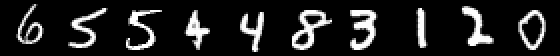

In [61]:
using Images
batchsize = 10
(x_disp, y_disp) = first(loader(test_data; batchsize))
xs = [Variable(x_disp[(i*196+1):((i+1)*196), :]) for i in 0:3]
y = Variable(y_disp)

ŷ = net(xs)
graph = topological_sort(ŷ)

reset_hidden_state()

forward!(graph)
println("ŷ = ", Flux.onecold(ŷ.output) .- 1)
println("y = ", Flux.onecold(y_disp) .- 1)
println("correct guesses: ", sum(Flux.onecold(ŷ.output) .== Flux.onecold(y_disp)), " / ", batchsize)

vector_of_matrices = [reshape(x_disp[:, i], 28, 28) for i in 1:size(x_disp, 2)]
fixed_matrices = [reverse(transpose(reverse((matrix), dims=1)), dims=2) for matrix in vector_of_matrices]
horizontal_image = hcat(fixed_matrices...)
Images.colorview(Gray, horizontal_image)